In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# DATA_PATH = 'drive/My Drive/Colab Notebooks/traffic_signs_detection'
DATA_PATH = 'data'

In [17]:
import matplotlib.pyplot as plt
import os
from shutil import copyfile
from shutil import rmtree
import random

%matplotlib inline

In [19]:
# rmtree('data')

In [20]:
# from shutil import copytree

# copytree('drive/My Drive/Colab Notebooks/traffic_signs_detection', 'data')

'data'

Доля тренировочных, валидационных и тестовых данных

In [21]:
part_train = 0.6
part_validation = 0.2
# part_test = 0.2 # будет по остаточному принципу

Пути к папкам с фотографиями

ВНИМАНИЕ: фоторгафии в этих папках должны располагаться в поддиректориях sign и no_sign при наличии и, соответственно, отсутствии дорожного знака на них.

ВНИМАНИЕ: кол-во фотографий со знаками и без них должно быть равно медлу собой для каждой группы (кол-во фоток city без знака равно кол-ву фоток city со знаком и т.д.)

In [22]:
city_path = f'{DATA_PATH}/city'
town_path = f'{DATA_PATH}/town'
town_2_path = f'{DATA_PATH}/town_2'
field_path = f'{DATA_PATH}/field'

Функция создает директорию traffic_signs_data, в ней поддиректории train, validation, test и в них поддиректории sign и no_sign. Далее берет все фотографии из указанных выше путей (city_path, ...) (массив путей передается в нее) и рандомно распределяет эти фотографии в поддиректирии train validation test и их поддиректории sign и no sign в соответствии с пропорциями part_train и part_validation, указанными выше. 

In [23]:
def collect_pics(paths):

  try:
    rmtree('traffic_signs_data')
  except:
    pass

  print('removed old dir')

  os.mkdir('traffic_signs_data')
  os.mkdir('traffic_signs_data/train')
  os.mkdir('traffic_signs_data/validation')
  os.mkdir('traffic_signs_data/test')
  os.mkdir('traffic_signs_data/train/sign')
  os.mkdir('traffic_signs_data/train/no_sign')
  os.mkdir('traffic_signs_data/validation/sign')
  os.mkdir('traffic_signs_data/validation/no_sign')
  os.mkdir('traffic_signs_data/test/sign')
  os.mkdir('traffic_signs_data/test/no_sign')

  print('created new dirs')

  for path in paths:

    pics_sign = list(os.walk(f'{path}/sign'))[0][2]
    pics_no_sign = list(os.walk(f'{path}/no_sign'))[0][2]
    random.shuffle(pics_sign,)
    random.shuffle(pics_no_sign)

    print('shuffled pics')

    num_train_sign = round(len(pics_sign) * part_train)
    num_validation_sign = round(len(pics_sign) * part_validation)
    num_test_sign = len(pics_sign) - num_train_sign - num_validation_sign
    num_train_no_sign = round(len(pics_no_sign) * part_train)
    num_validation_no_sign = round(len(pics_no_sign) * part_validation)
    num_test_no_sign = len(pics_no_sign) - num_train_no_sign - num_validation_no_sign

    print('calculated nums of pics:', num_train_sign, num_validation_sign, num_test_sign,
          num_train_no_sign, num_validation_no_sign, num_test_no_sign)

    pics_train_sign = pics_sign[:num_train_sign]
    pics_validation_sign = pics_sign[num_train_sign : num_train_sign + num_validation_sign]
    pics_test_sign = pics_sign[-num_test_sign:]
    pics_train_no_sign = pics_no_sign[:num_train_no_sign]
    pics_validation_no_sign = pics_no_sign[num_train_no_sign : num_train_no_sign + num_validation_no_sign]
    pics_test_no_sign = pics_no_sign[-num_test_no_sign:]


    for pic in pics_train_sign:
      copyfile(f'{path}/sign/{pic}', f'traffic_signs_data/train/sign/{pic}')

    for pic in pics_validation_sign:
      copyfile(f'{path}/sign/{pic}', f'traffic_signs_data/validation/sign/{pic}')

    for pic in pics_test_sign:
      copyfile(f'{path}/sign/{pic}', f'traffic_signs_data/test/sign/{pic}')

    for pic in pics_train_no_sign:
      copyfile(f'{path}/no_sign/{pic}', f'traffic_signs_data/train/no_sign/{pic}')

    for pic in pics_validation_no_sign:
      copyfile(f'{path}/no_sign/{pic}', f'traffic_signs_data/validation/no_sign/{pic}')

    for pic in pics_test_no_sign:
      copyfile(f'{path}/no_sign/{pic}', f'traffic_signs_data/test/no_sign/{pic}')

    print('pics successfully copied')

Распеделяем фотки по директориям

In [30]:
paths = [town_path, city_path, field_path]

collect_pics(paths)

num_train = len(list(os.walk(f'traffic_signs_data/train/sign'))[0][2])
num_validation = len(list(os.walk(f'traffic_signs_data/validation/sign'))[0][2])
num_test = len(list(os.walk(f'traffic_signs_data/test/sign'))[0][2])

removed old dir
created new dirs
shuffled pics
calculated nums of pics: 18 6 6 18 6 6
pics successfully copied
shuffled pics
calculated nums of pics: 15 5 5 15 5 5
pics successfully copied
shuffled pics
calculated nums of pics: 21 7 7 22 7 7
pics successfully copied


Итого каждая директория train, validation и test содержит соответственно картинок:

In [31]:
print(num_train, num_validation, num_test)

54 18 18


Обучаем сеточку

In [32]:


from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = f'traffic_signs_data/train'
validation_data_dir = f'traffic_signs_data/validation'
test_data_dir = f'traffic_signs_data/test'

nb_train_samples = num_train
nb_validation_samples = num_validation
epochs = 100
batch_size = 4

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))#########################################
# model.add(Activation('relu'))##########################################
# model.add(MaxPooling2D(pool_size=(2, 2)))################################

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss='binary_crossentropy',
              # optimizer='rmsprop',
              optimizer=optimizer,
              metrics=['accuracy'],)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size, )

# model.save_weights('first_try.h5')

Found 109 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
13/13 [==============================] - 3s 209ms/step - loss: 0.7072 - accuracy: 0.4435 - val_loss: 0.6963 - val_accuracy: 0.4375
Epoch 2/100
13/13 [==============================] - 2s 115ms/step - loss: 0.6749 - accuracy: 0.5684 - val_loss: 0.6597 - val_accuracy: 0.6250
Epoch 3/100
13/13 [==============================] - 2s 124ms/step - loss: 0.7465 - accuracy: 0.4789 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 4/100
13/13 [==============================] - 2s 132ms/step - loss: 0.6691 - accuracy: 0.5411 - val_loss: 0.6809 - val_accuracy: 0.5625
Epoch 5/100
13/13 [==============================] - 3s 205ms/step - loss: 0.6946 - accuracy: 0.5362 - val_loss: 0.6967 - val_accuracy: 0.4375
Epoch 6/100
13/13 [==============================] - 2s 127ms/step - loss: 0.6658 - accuracy: 0.5301 - val_loss: 0.7003 - val_accuracy: 0.4375
Epoch 7/100
13/13 [==============================] - 2s 152ms/step - loss: 0.7045 - accuracy: 0.4330 - val_loss: 0.6879 - val_accuracy: 0.5625

Создаем генератор для тестирования

ВНИМАНИЕ: для тестирования на своей выборке (после того как моделька обучилась), надо в  test_data_dir, находящуюся в директории traffic_signs_data положить свои фото. При этом, необходимо, чтобы фото со знаками располагались в поддиректории sign, а фото без знаков в поддиректории no_sign. Это требуется для корректного подсчета accuracy.

ВНИМАНИЕ: Также, необходимо, чтобы кол-во тестовых фоток без знака равнялось кол-ву тестовых фоток со знаком.

In [33]:

test_datagen = ImageDataGenerator(rescale=1. / 255)


test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 36 images belonging to 2 classes.


Отрисовываем фотки и лейблы (истинные и предсказанные) (no_sign == 0, а sign == 1).


Pic №1
class: no_sign:
prediction: 0.31569012999534607 (0)


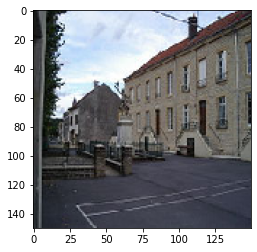


Pic №2
class: sign:
prediction: 0.8363933563232422 (1)


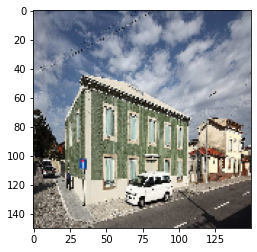


Pic №3
class: no_sign:
prediction: 0.6888793706893921 (1)


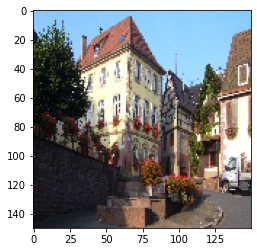


Pic №4
class: no_sign:
prediction: 0.14024478197097778 (0)


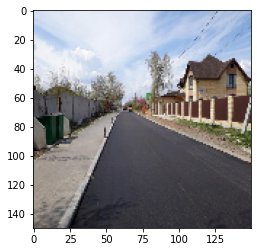


Pic №5
class: no_sign:
prediction: 0.551255464553833 (1)


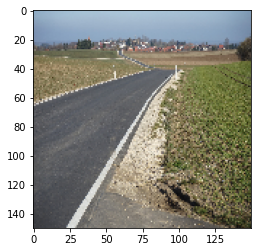


Pic №6
class: no_sign:
prediction: 0.811008632183075 (1)


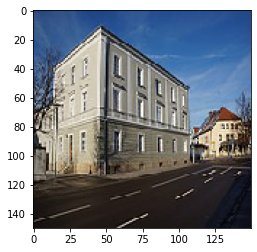


Pic №7
class: no_sign:
prediction: 0.025713717564940453 (0)


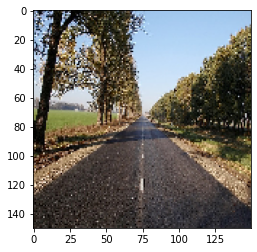


Pic №8
class: no_sign:
prediction: 0.4941188395023346 (0)


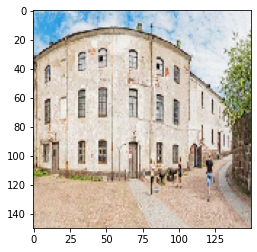


Pic №9
class: sign:
prediction: 0.168593630194664 (0)


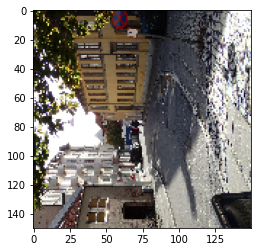


Pic №10
class: sign:
prediction: 0.9112055897712708 (1)


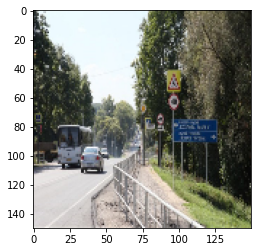


Pic №11
class: sign:
prediction: 0.4037339389324188 (0)


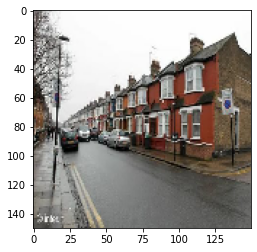


Pic №12
class: sign:
prediction: 0.5408715605735779 (1)


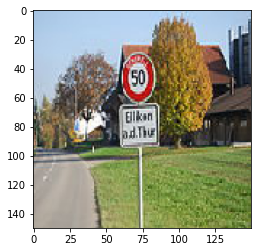


Pic №13
class: no_sign:
prediction: 0.391082227230072 (0)


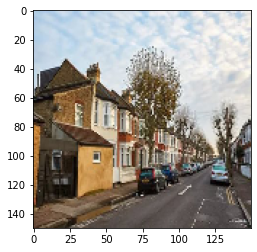


Pic №14
class: sign:
prediction: 0.6965171098709106 (1)


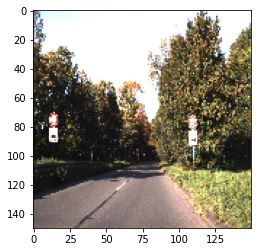


Pic №15
class: sign:
prediction: 0.7274826765060425 (1)


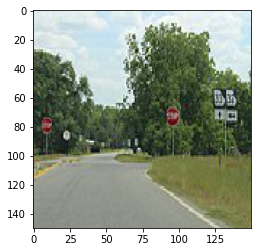


Pic №16
class: sign:
prediction: 0.3555288016796112 (0)


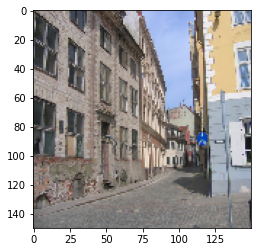


Pic №17
class: sign:
prediction: 0.5414184927940369 (1)


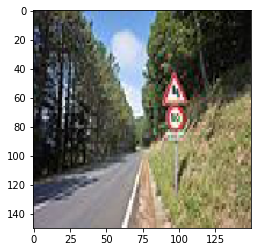


Pic №18
class: sign:
prediction: 0.3489154279232025 (0)


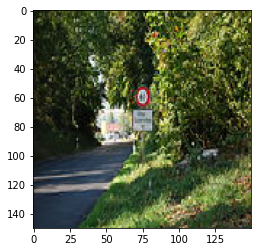


Pic №19
class: no_sign:
prediction: 0.308233380317688 (0)


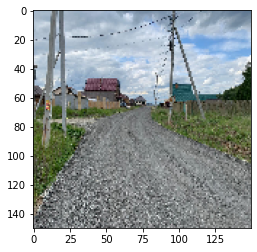


Pic №20
class: no_sign:
prediction: 0.31902045011520386 (0)


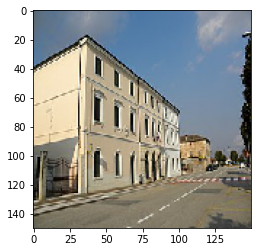


Pic №21
class: sign:
prediction: 0.22541548311710358 (0)


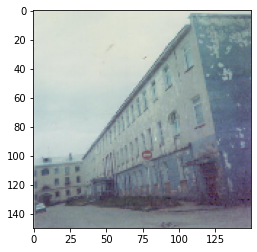


Pic №22
class: no_sign:
prediction: 0.5711000561714172 (1)


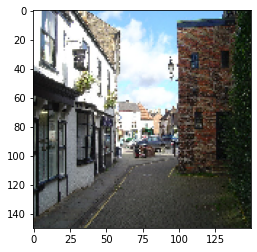


Pic №23
class: sign:
prediction: 0.2797379791736603 (0)


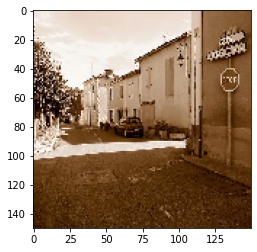


Pic №24
class: no_sign:
prediction: 0.41457849740982056 (0)


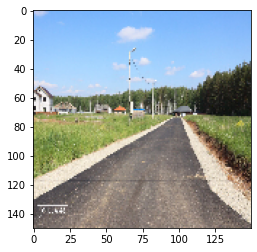


Pic №25
class: sign:
prediction: 0.33954331278800964 (0)


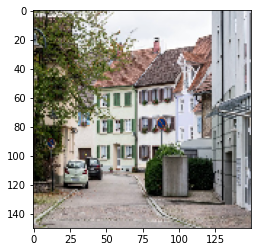


Pic №26
class: no_sign:
prediction: 0.023211082443594933 (0)


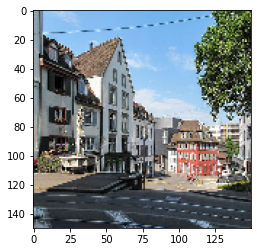


Pic №27
class: no_sign:
prediction: 0.5351893305778503 (1)


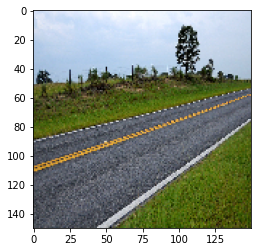


Pic №28
class: sign:
prediction: 0.38190606236457825 (0)


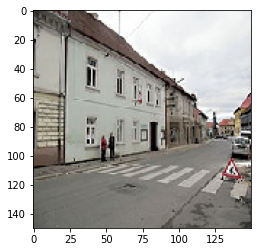


Pic №29
class: no_sign:
prediction: 0.23144158720970154 (0)


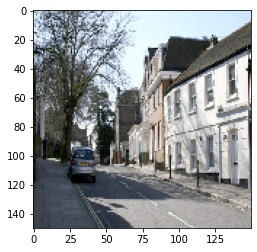


Pic №30
class: sign:
prediction: 0.7136826515197754 (1)


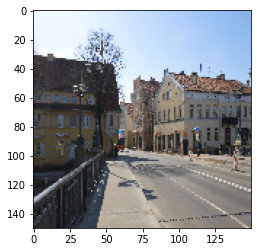


Pic №31
class: no_sign:
prediction: 0.40180304646492004 (0)


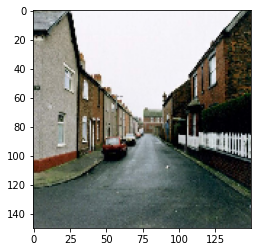


Pic №32
class: sign:
prediction: 0.819591760635376 (1)


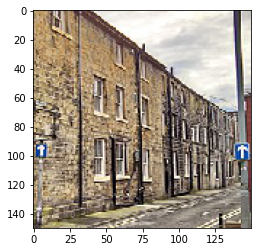


Pic №33
class: no_sign:
prediction: 0.0019579429645091295 (0)


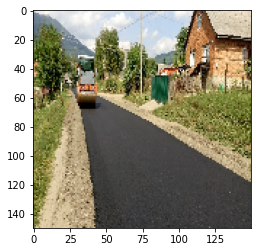


Pic №34
class: sign:
prediction: 0.11870977282524109 (0)


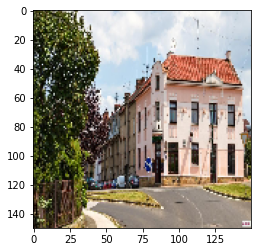


Pic №35
class: no_sign:
prediction: 0.2104870080947876 (0)


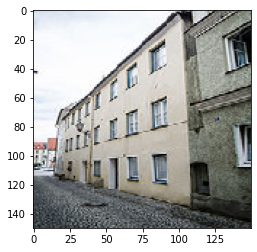


Pic №36
class: sign:
prediction: 0.7323925495147705 (1)


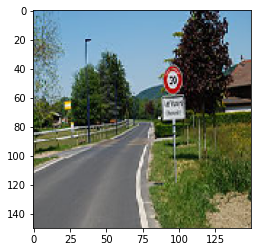

In [34]:
import math

classes = {0: 'no_sign', 1: 'sign'}

y_true = list()
y_pred = list()

def rounder(x, thr=0.5):
  if x >= thr:
    return 1
  else:
    return 0

test_generator.reset()
cnt = 1
for j in range(math.ceil(num_test * 2 / batch_size)):
  x,y = test_generator.next()
  p = model.predict(x)
  for i in range(0,batch_size):

      print(f'\nPic №{cnt}')
      cnt += 1
      # print(x.shape)
      # print(x[0].shape)
      # print(x[3].shape)

      # pred_idx = j * batch_size + i
      pred = p[i]

      y_true.append(y[i])
      y_pred.append(rounder(pred[0]))
      
      # break
      image = x[i]
      # plt.imshow(image.transpose(2,1,0))
      print(f'class: {classes[y[i]]}:\nprediction: {float(pred)} ({rounder(pred[0])})')
      plt.imshow(image)
      plt.show()
      if cnt == num_test * 2 + 1:
        break

Вычисляем accuracy.

In [35]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.6111111111111112

Как видим, accuracy неплохой

Для получения значений выше 90% можно оставить только field_path (загородные дороги). На них предсказания получаются значительно лучше, ибо в городе присутствует слишком много объектов, напоминающих дорожные знаки.